**Multi-Stock Monte Carlo Simulation (Independent GBM)**

In this notebook, I learned simulate several independent stocks using Geometric Brownian Motion (GBM).
Each stock has its own expected return and volatility, but no correlation with others.

I learned learn how to:

Extend Monte Carlo logic to multiple assets

Visualize uncertainty for each stock in a single chart

Understand how volatility affects the spread of simulated price paths

This step prepares me for correlation and start true portfolio simulations.

/tmp/ipython-input-773004529.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw = yf.download(tickers, start=start, end=end)
[*********************100%***********************]  5 of 5 completed
/tmp/ipython-input-773004529.py:49: FutureWarning: YF.download() has changed argument auto_adjust default to True
  d = yf.download(t, start=start, end=end, progress=False)
/tmp/ipython-input-773004529.py:49: FutureWarning: YF.download() has changed argument auto_adjust default to True
  d = yf.download(t, start=start, end=end, progress=False)
/tmp/ipython-input-773004529.py:49: FutureWarning: YF.download() has changed argument auto_adjust default to True
  d = yf.download(t, start=start, end=end, progress=False)
/tmp/ipython-input-773004529.py:49: FutureWarning: YF.download() has changed argument auto_adjust default to True
  d = yf.download(t, start=start, end=end, progress=False)
/tmp/ipython-input-773004529.py:49: FutureWarning: YF.download() has chang

Tickers used in simulation: ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META']


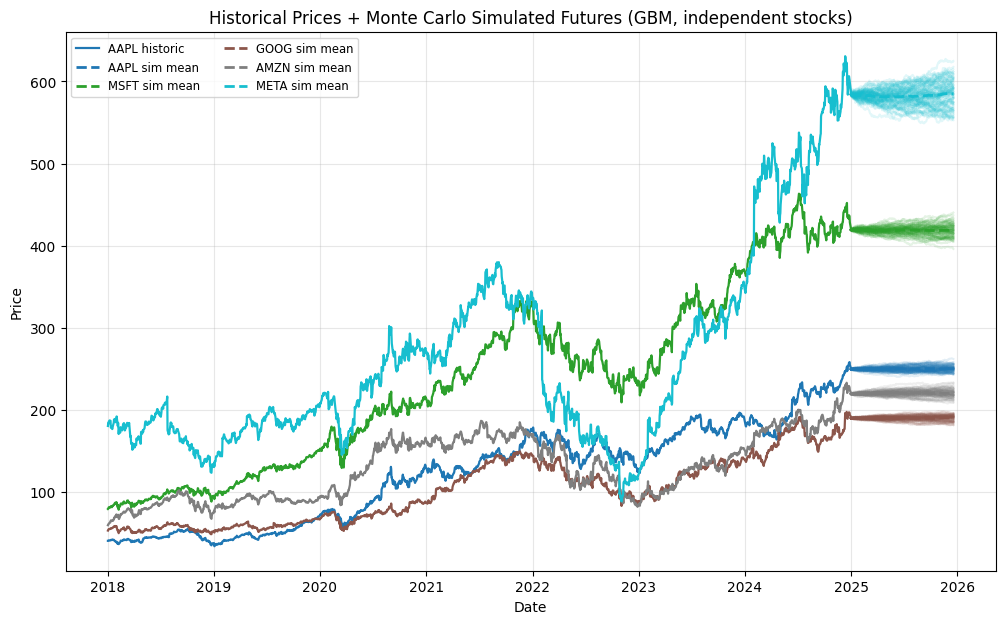

In [24]:
# Robust: Historical + Monte Carlo futures (independent GBM) — Colab-ready
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

tickers = ["AAPL","MSFT","GOOG","AMZN","META"]
start = "2018-01-01"
end = "2025-01-01"

# 1) Try bulk download and clean Adj Close
raw = yf.download(tickers, start=start, end=end)

# Flatten multiindex if present
if isinstance(raw.columns, pd.MultiIndex):
    raw.columns = ['_'.join([str(x) for x in col]).strip() for col in raw.columns.values]

# Collect Adj Close columns if present
adj_cols = [c for c in raw.columns if 'Adj Close' in c or 'AdjClose' in c or c.lower().endswith('adj close')]
adj = pd.DataFrame()
if adj_cols:
    # map columns to tickers where possible
    # if flattened as 'AAPL_Adj Close' or 'Adj Close_AAPL' try to extract ticker
    for c in adj_cols:
        parts = c.replace('Adj Close', '').replace('AdjClose','').replace('_',' ').strip().split()
        # find any known ticker string in parts
        ticker_found = None
        for p in parts:
            if p.upper() in [t.upper() for t in tickers]:
                ticker_found = next(t for t in tickers if t.upper() == p.upper())
                break
        # fallback: try to take prefix before 'Adj'
        if not ticker_found:
            # try split by '_' and take left or right
            if '_' in c:
                left,right = c.split('_',1)
                if left.upper() in [t.upper() for t in tickers]:
                    ticker_found = next(t for t in tickers if t.upper() == left.upper())
                elif right.upper() in [t.upper() for t in tickers]:
                    ticker_found = next(t for t in tickers if t.upper() == right.upper())
        if ticker_found:
            adj[ticker_found] = raw[c]

# 2) If adj is empty or missing some tickers, download each ticker individually (robust fallback)
missing = [t for t in tickers if t not in adj.columns]
if missing:
    for t in missing:
        try:
            d = yf.download(t, start=start, end=end, progress=False)
            if 'Adj Close' in d.columns:
                adj[t] = d['Adj Close']
            elif 'Close' in d.columns:
                adj[t] = d['Close']
        except Exception as e:
            print(f"Failed to download {t}: {e}")

# Keep only tickers that have data (non-empty)
adj = adj.dropna(how='all', axis=1)  # drop columns that are all NaN
available = list(adj.columns)
if len(available) == 0:
    raise ValueError("No adjusted close data available for the requested tickers. Check ticker names or network access.")

# Reorder to requested tickers but only those available
available = [t for t in tickers if t in adj.columns]
adj = adj[available].ffill().dropna()

print("Tickers used in simulation:", available)

# Compute returns and stats
returns = adj.pct_change().dropna()
if returns.shape[0] < 2:
    raise ValueError("Not enough return observations to compute statistics. Try a longer history range.")
mus = returns.mean().values
sigmas = returns.std().values
last_prices = adj.iloc[-1].values

# Simulation params
n_days = 252
n_sims = 75

plt.figure(figsize=(12,7))
colors = plt.cm.tab10(np.linspace(0,1,len(available)))

for i, ticker in enumerate(available):
    mu, sigma, S0 = mus[i], sigmas[i], last_prices[i]
    dt = 1 / n_days
    rand = np.random.normal(0,1,(n_days, n_sims))
    factors = np.exp((mu - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*rand)
    future_paths = np.vstack((np.full((1,n_sims), S0), S0 * np.cumprod(factors, axis=0)))
    future_index = pd.bdate_range(start=adj.index[-1], periods=n_days+1, freq='B')

    # Plot historical
    plt.plot(adj.index, adj[ticker], color=colors[i], lw=1.6, label=f"{ticker} historic" if i==0 else "")
    # Plot futures
    for j in range(n_sims):
        plt.plot(future_index, future_paths[:,j], color=colors[i], alpha=0.12)
    # Mean simulated future (dashed)
    plt.plot(future_index, future_paths.mean(axis=1), color=colors[i], lw=2, linestyle='--', label=f"{ticker} sim mean")

plt.title("Historical Prices + Monte Carlo Simulated Futures (GBM, independent stocks)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(ncol=2, fontsize='small')
plt.grid(True, alpha=0.3)
plt.show()
